In [2]:
import os
import json

In [3]:
if not os.path.exists('/content/data/'):

  api_token = {"username": "prabeshsharma",
                  "key": "e8929420b0f14df13c668815eef404a0"}

  with open('/content/kaggle.json', 'w') as file:
      json.dump(api_token, file)

  os.environ["KAGGLE_CONFIG_DIR"] = "/content/"

  os.system('kaggle datasets download -d prabeshsharma/vgg16featureextraction-ucfcrime-data')
  os.makedirs('/content/data/', exist_ok=True)
  os.system('mv /content/vgg16featureextraction-ucfcrime-data.zip /content/data/vgg16featureextraction-ucfcrime-data.zip')
  os.system('unzip -q /content/data/vgg16featureextraction-ucfcrime-data.zip -d /content/data/')
  os.remove('/content/data/vgg16featureextraction-ucfcrime-data.zip')

In [2]:
import numpy as np
import pickle
import os
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Path to the directory containing pickle files for each video
train_data_dir = '/content/data/Vgg16FeatureExtractedData/TrainFeature'
test_data_dir = '/content/data/Vgg16FeatureExtractedData/TestFeature'

# Function to load the features and labels
def load_data(data_dir):
    features, labels = [], []
    for class_dir in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_dir)
        for file in os.listdir(class_path):
            file_path = os.path.join(class_path, file)
            with open(file_path, 'rb') as f:
                video_features = pickle.load(f)  # Assuming features are saved as numpy arrays
            features.append(video_features)
            # Create label: 0 for Normal Videos, 1 for Abnormal Videos
            label = 0 if class_dir == 'NormalVideos' else 1
            labels.append(label)

    # Find the maximum sequence length
    # max_length = max(len(feature) for feature in features)
    max_length = 500

    # Pad all features to have the same length
    features_padded = pad_sequences(features, maxlen=max_length, padding='post', dtype='float32')

    return np.array(features_padded), np.array(labels)

# Load the training and testing data
Trainfeatures, Trainlabels = load_data(train_data_dir)
Testfeatures, Testlabels = load_data(test_data_dir)

# Convert labels to one-hot encoding for binary classification
Trainlabels = np.eye(2)[Trainlabels]
Testlabels = np.eye(2)[Testlabels]

print("Training Features Shape:", Trainfeatures.shape)
print("Training Labels Shape:", Trainlabels.shape)
print("Test Features Shape:", Testfeatures.shape)
print("Test Labels Shape:", Testlabels.shape)


Training Features Shape: (1079, 500, 512)
Training Labels Shape: (1079, 2)
Test Features Shape: (222, 500, 512)
Test Labels Shape: (222, 2)


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a custom transformer encoder layer
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, output_shape=embed_dim)
        self.ffn = models.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim)  # FFN output matches embed_dim
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        # Multi-head self-attention layer
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # Residual connection + normalization

        # Feed-forward network
        ffn_output = self.ffn(out1)  # FFN output dimension matches embed_dim
        ffn_output = self.dropout2(ffn_output, training=training)

        # Residual connection + normalization
        return self.layernorm2(out1 + ffn_output)

# Define the Transformer-based model
def create_transformer_model(input_shape, embed_dim=512, num_heads=4, ff_dim=512):
    inputs = layers.Input(shape=input_shape)

    # Transformer Encoder block
    x = TransformerEncoder(embed_dim, num_heads, ff_dim)(inputs)

    # Global pooling to reduce sequence dimension
    x = layers.GlobalAveragePooling1D()(x)

    # Dense layers for classification
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
    outputs = layers.Dense(2, activation='softmax')(x)  # 2 output units for binary classification

    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the transformer model
input_shape = (Trainfeatures.shape[1], Trainfeatures.shape[2])  # e.g., (n_frames, feature_dim)
transformer_model = create_transformer_model(input_shape)

# Model summary
transformer_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 500, 512)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_5                │ (None, 500, 512)            │       4,728,320 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,761,282 (18.16 MB)

 Trainable params: 4,761,282 (18.16 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = transformer_model.fit(Trainfeatures, Trainlabels,
                                epochs=10,
                                batch_size=32,
                                validation_data=(Testfeatures, Testlabels))

Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 33s 574ms/step - accuracy: 0.5329 - loss: 1.0851 - val_accuracy: 0.6306 - val_loss: 0.6577
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.6119 - loss: 0.6647 - val_accuracy: 0.6306 - val_loss: 0.6572
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.5986 - loss: 0.6768 - val_accuracy: 0.6306 - val_loss: 0.6577
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.6111 - loss: 0.6738 - val_accuracy: 0.6306 - val_loss: 0.6566
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.6269 - loss: 0.6633 - val_accuracy: 0.6306 - val_loss: 0.6558
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.6052 - loss: 0.6736 - val_accuracy: 0.6306 - val_loss: 0.6523
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.6017 - loss: 0.6731 - val_accuracy: 0.6306 - val_loss: 0.6428
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.5986 - loss: 0.6694 - val_accurac

In [12]:
import matplotlib.pyplot as plt
def plot_graphs(histoy, string):
    plt.plot(histoy.history[string])
    plt.plot(histoy.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()

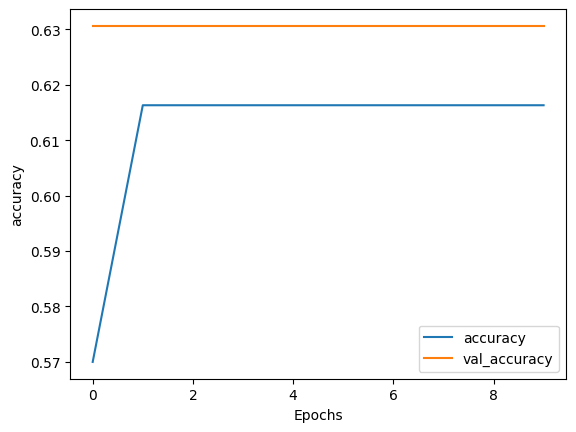

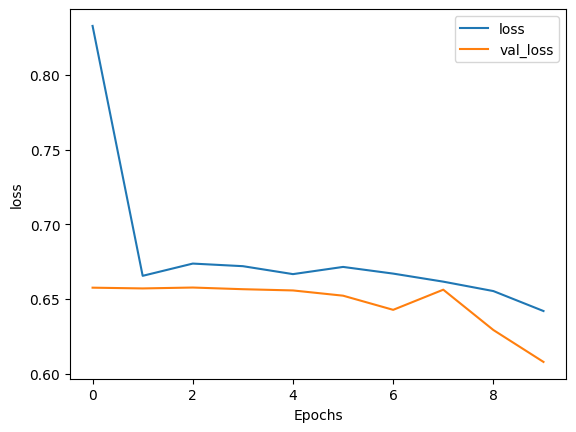

In [13]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [15]:
# Evaluate the model on the validation set
val_loss, val_acc = transformer_model.evaluate(Testfeatures, Testlabels, verbose=2)
print(f"Validation accuracy: {val_acc:.4f}")


7/7 - 1s - 89ms/step - accuracy: 0.6306 - loss: 0.6080
Validation accuracy: 0.6306


In [16]:
# Save the model
transformer_model.save('transformer_video_classifier.h5')

In [3]:
import cv2
import os

# Folder containing the extracted frames
frames_folder = '/Users/prabeshsharma/Documents/Unsual_activity_Detection/Dataset_Folder/Datasets/Train/RoadAccidents/RoadAccidents003_x264'

# Output video file path
output_video = 'output_video.mp4'

# Define frame size (width, height) and frame rate (fps)
frame_size = (224, 224)  # Adjust according to your frame dimensions
fps = 10  # Set the frame rate

# Get the list of frames and sort them (if they are named sequentially)
frames = [os.path.join(frames_folder, f) for f in os.listdir(frames_folder) if f.endswith('.png') or f.endswith('.jpg')]
frames.sort()

# Initialize video writer with codec, fps, and frame size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can use different codecs like 'mp4v'
video_writer = cv2.VideoWriter(output_video, fourcc, fps, frame_size)

# Write each frame to the video
for frame in frames:
    img = cv2.imread(frame)
    resized_frame = cv2.resize(img, frame_size)  # Resize frame if necessary
    video_writer.write(resized_frame)

# Release the video writer
video_writer.release()

print(f"Video saved as {output_video}")


Video saved as output_video.mp4
